In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot

from sklearn.metrics import classification_report, mean_squared_error, r2_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.svm import SVC

import warnings
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
from matplotlib import style

In [84]:
# load the raw DataFrame
df = pd.read_csv("/Users/sa18/Desktop/Financial_Fraud/fin_fraud_data.csv")

In [85]:
# drop columns that will not be analyzed & save to a new DataFrame
cleaned_df = df.drop(columns=["step", "nameOrig", "nameDest", "isFlaggedFraud"])

cleaned_df

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1


In [86]:
# check for duplicates
cleaned_df.duplicated().sum()

97880

In [87]:
# check for missing values
cleaned_df.isna().sum()

type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [88]:
# shape of revised DataFrame
cleaned_df.shape

(6362620, 7)

In [89]:
cleaned_df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [90]:
# list the columns
cleaned_df.columns

Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud'],
      dtype='object')

In [91]:
# check dataframe types
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            object 
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 339.8+ MB


In [92]:
# info and stats about data set
cleaned_df.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [93]:
# get type counts 
type_counts = cleaned_df.value_counts("type")
type_counts.to_frame()

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


In [94]:
# filter to analyze only these types
df_filtered = cleaned_df[cleaned_df['type'].isin(['CASH_OUT', 'TRANSFER'])]
df_filtered

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,TRANSFER,181.00,181.00,0.0,0.00,0.00,1
3,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,1
15,CASH_OUT,229133.94,15325.00,0.0,5083.00,51513.44,0
19,TRANSFER,215310.30,705.00,0.0,22425.00,0.00,0
24,TRANSFER,311685.89,10835.00,0.0,6267.00,2719172.89,0
...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1
6362616,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1
6362617,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1
6362618,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1


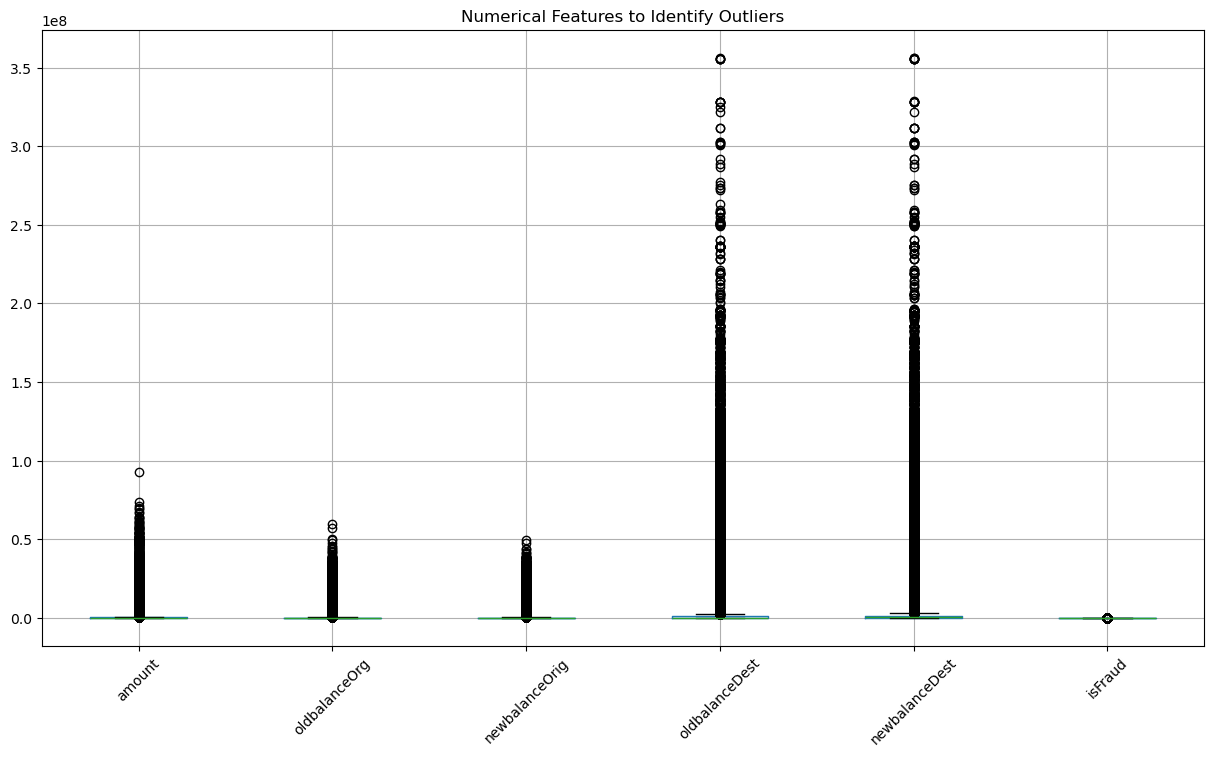

In [95]:
# check for outliers in cleaned dataset
plt.figure(figsize=(15,8))
cleaned_df.boxplot(rot=45)
plt.title("Numerical Features to Identify Outliers")
plt.show()

In [96]:
# Normalize numerical data using StandardScaler
scaler = StandardScaler()
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
cleaned_df[numerical_features] = scaler.fit_transform(cleaned_df[numerical_features])

In [97]:
# apply one-hot encoding to "type" column to convert categorical to numerical 
cleaned_df = pd.get_dummies(cleaned_df, columns=['type'], dtype=int, drop_first=True)

In [98]:
# check DataFrame to ensure conversion was successful
cleaned_df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411,0,0,0,1,0
1,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411,0,0,0,1,0
2,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411,1,0,0,0,1
3,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411,1,1,0,0,0
4,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411,0,0,0,1,0


In [99]:
# save cleaned DataFrame to CSV file
cleaned_df.to_csv('cleaned_data.csv', index=False)